In [80]:
import csv
import numpy as np # linear algebra
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection  import  train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt

# personal imports
import data_extractor
from encoder_categorical_numerical import Encoder_Categorical_Numerical
import accuracy_extractor

In [81]:
validation = False
index_beginning_actions = 4
upper_limit_seconds = 300
lower_limit_seconds = 15

training_file = "./input/TRAIN.CSV" if not validation else "./input/minitrain.csv"
validation_file = "./input/minitest.csv"
#validation_file
testing_file = "./input/TEST.CSV" if not validation else "./input/minitest.csv"

### Calculer le temps moyen d'une partie

In [82]:
def __ceil_to_five__(seconds):
    """Approximates the number of seconds to the upper multiple of 5.
    :param seconds: number of seconds to approximate
    :return: approxilated seconds
    """
    modulo = seconds % 5
    if modulo == 0:
        return seconds
    else:
        return seconds - modulo + 5

In [83]:
def __remove_tX__(row):
    """Get a new list of words with words of type tX (X a number) removed
    :param myrow: a list of words"""
    tX = re.compile("t\d")
    new_row = []
    for cell in row:
        if tX.match(cell):
            pass
        else:
            new_row.append(cell)
    return new_row

In [84]:
def __get_maximum_time_match__(row, default_time=0):
    """Get the approximate time of a match
    :param myrow: one match"""
    tX = re.compile("t\d")
    for cell in row[::-1]:
        if tX.match(cell):
            return int(cell[1:])
    return default_time

In [85]:
a = ["t5", "a","b","c", "t18","a","b","c", "t150", "a","b"]
__get_maximum_time_match__(a, 0)

150

### Calculer le temps moyen entre deux actions

In [86]:
def __get_speed__(row, max_time):
    tX = re.compile("t\d")
    nb_actions = len(row)
    for cell in row:
        if tX.match(cell):
            nb_actions = nb_actions-1
    return max_time/nb_actions

In [87]:
a = ["t5", "a","b","c", "t18","a","b","c", "t150", "a","b"]
__get_speed__(a, 150)

18.75

### Connaître toutes les actions possibles

In [88]:
def __recognise_possible_actions__(set_of_actions, row):
    for cell in row[index_beginning_actions:]:
        set_of_actions.add(cell)
    return set_of_actions

# Get dataframe

In [89]:
def get_dataframe(path_file, training, upper_limit_seconds, lower_limit_seconds):
    """
    :param path_file:
    :param training: boolean
    :param limit_seconds: int
    :return: A DataFrame with columns named id_player, played_race, 0... n, with n the number of kept actions.
    """
    upper_limit_seconds = __ceil_to_five__(upper_limit_seconds)
    upper_stop_word = "t" + str(upper_limit_seconds)
    lower_limit_seconds = __ceil_to_five__(lower_limit_seconds)
    lower_stop_word = "t" + str(lower_limit_seconds)
    
    extracted = []
    largest_column_count = 0
    possible_actions = set()
    index_new_feature = 2 if training else 1
    lower_column_to_keep = []

    # Loop the data lines
    with open(path_file) as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\n')
        for row in spamreader:
            myrow = row[0].split(',')
            try:
                upper_stop_index = myrow.index(upper_stop_word)
            except:
                upper_stop_index = -1
            try:
                lower_stop_index = myrow.index(lower_stop_word)
            except:
                lower_stop_index = -1
            #compute the time of a match and the average speed between two actions
            time_match = __get_maximum_time_match__(myrow)
            average_speed_match = __get_speed__(myrow, time_match)
            #compute the number of columns to keep for ordered actions
            lower_column_to_keep.append(len(__remove_tX__(myrow[index_new_feature:lower_stop_index]))-1)
            #delete useless tX
            myrow = __remove_tX__(myrow[0:upper_stop_index])
            #know possible set of actions
            possible_actions = __recognise_possible_actions__(possible_actions, myrow)
            #compute the average speed between two actions for a specifical time lapse
            #average_speed_limited_time = __get_speed__(myrow, limit_seconds)
            #insert time_match and average_speed_match as features
            myrow.insert(index_new_feature, time_match)
            myrow.insert(index_new_feature+1, average_speed_match)         
            #myrow.insert(index_time_match+2, average_speed_limited_time)
            #count the number of columns
            largest_column_count = max(len(myrow), largest_column_count)
            extracted.append(myrow)
    column_names = []
    if training:
        column_names = ["id_player", "played_race", "time_match", "average_speed_match"] + [(str(i)+"th_action") for i in range(0, largest_column_count - index_beginning_actions)]
    else:
        column_names = ["played_race", "time_match", "average_speed_match"] + [(str(i)+"th_action") for i in range(0, largest_column_count - index_beginning_actions+1)]
    return pd.DataFrame(extracted, columns = column_names), possible_actions, lower_column_to_keep

In [90]:
df_training, possible_actions_training, lower_column_to_keep_training = get_dataframe(training_file, training=True, upper_limit_seconds=upper_limit_seconds, lower_limit_seconds=lower_limit_seconds)
#df_testing, possible_actions_testing, lower_column_to_keep_testing = get_dataframe(testing_file, training=validation, upper_limit_seconds=upper_limit_seconds, lower_limit_seconds=lower_limit_seconds)
#possible_actions = list(possible_actions_training.union(possible_actions_testing))
possible_actions = possible_actions_training
#index to deleted ordered actions after t
index_column_to_delete = max(lower_column_to_keep_training)+index_beginning_actions+1
#index_column_to_delete = max((max(lower_column_to_keep_training)+index_beginning_actions), (max(lower_column_to_keep_testing)+index_beginning_actions-1))+1

In [91]:
index_column_to_delete

114

In [92]:
df_training.head()
#df_testing.head()

,id_player,played_race,time_match,average_speed_match,0th_action,1th_action,2th_action,3th_action,4th_action,5th_action,...,1786th_action,1787th_action,1788th_action,1789th_action,1790th_action,1791th_action,1792th_action,1793th_action,1794th_action,1795th_action
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,1655.0,0.740824,Base,s,s,s,s,s,...,None,None,None,None,None,None,None,None,None,None
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,1655.0,0.796056,s,Base,s,s,Base,s,...,None,None,None,None,None,None,None,None,None,None
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,1010.0,0.748148,Base,s,s,s,Base,s,...,None,None,None,None,None,None,None,None,None,None
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,1005.0,0.723022,Base,s,s,Base,s,s,...,None,None,None,None,None,None,None,None,None,None
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,540.0,0.869565,Base,s,s,s,Base,s,...,None,None,None,None,None,None,None,None,None,None


## NOT TO DO: Aligner le nombre de colonnes pour training and testing datasets

In [ ]:
columns_to_add = (set(df_training.columns) - set(df_testing.columns))-set(["id_player"])
for column in columns_to_add: 
    df_testing[column] = np.nan
if validation:
    training_columns_l = len(df_training.columns)-1
    testing_columns_l = len(df_testing.columns)
    if testing_columns_l>training_columns_l:
        columns_to_add = (set(df_testing.columns) - set(df_training.columns))-set(["id_player"])
        for column in columns_to_add: 
            df_training[column] = np.nan

## Last index for ordered_actions

In [93]:
index_end_actions = len(df_training.columns)

In [94]:
index_end_actions

1800

## Calculer l'occurence de chaque action pendant une durée donnée

In [95]:
def __row_of_occurence_actions__(actions, counts, list_of_all_actions):
    dict_of_occurence = {action: 0 for action in list_of_all_actions}
    for action, count in zip(actions, counts):
        dict_of_occurence[action] = count   
    return [int(dict_of_occurence[action]) for action in list_of_all_actions]
        
def __compute_occurence_actions__(df, list_of_all_actions, training=True):
    df_occurence_actions = pd.DataFrame(0, index=df.index, columns=list_of_all_actions, dtype=int)
    for index, row in df.iterrows():
        column_index_start = index_beginning_actions if training else index_beginning_actions-1
        row_to_examine = df.iloc[index,column_index_start:]
        actions, counts = np.unique(row_to_examine.dropna().values, return_counts=True)
        df_occurence_actions.iloc[index,] = __row_of_occurence_actions__(actions, counts, list_of_all_actions)
    return df.join(df_occurence_actions)

In [96]:
df_training = __compute_occurence_actions__(df_training, possible_actions)
#df_testing = __compute_occurence_actions__(df_testing, possible_actions, validation)

In [97]:
df_training.head()

,id_player,played_race,time_match,average_speed_match,0th_action,1th_action,2th_action,3th_action,4th_action,5th_action,...,hotkey41,hotkey91,hotkey30,s,hotkey40,Base,hotkey62,hotkey71,SingleMineral,hotkey11
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,1655.0,0.740824,Base,s,s,s,s,s,...,0,0,1,127,1,3,0,0,4,0
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,1655.0,0.796056,s,Base,s,s,Base,s,...,0,0,2,139,1,4,0,0,0,0
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,1010.0,0.748148,Base,s,s,s,Base,s,...,0,0,1,158,3,2,0,0,2,0
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,1005.0,0.723022,Base,s,s,Base,s,s,...,0,0,3,121,1,4,0,0,0,0
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,540.0,0.869565,Base,s,s,s,Base,s,...,0,0,1,138,1,2,0,0,0,0


## Delete colums to have lower ordered actions

In [98]:
def __delete_columns_for_lower_limit__(df, begin_index, end_index):
    columns_to_delete = list(df.columns[begin_index:end_index])
    return df.drop(columns_to_delete, axis=1)

#### if we want to delete everything as ordonnancy of actions?

In [99]:
df_training = __delete_columns_for_lower_limit__(df_training, index_column_to_delete, index_end_actions)
#df_testing = __delete_columns_for_lower_limit__(df_testing, index_column_to_delete, index_end_actions)
index_end_actions = index_column_to_delete

## Encode values

In [100]:
#Encodage
encoder = Encoder_Categorical_Numerical(df_training, index_beginning_actions, index_end_actions)
df_encoded_training = encoder.encode_df(df_training)
#df_encoded_testing = encoder.encode_df(df_testing, validation)

In [101]:
df_encoded_training.head()
#df_encoded_testing.head()

,id_player,played_race,time_match,average_speed_match,0th_action,1th_action,2th_action,3th_action,4th_action,5th_action,...,hotkey41,hotkey91,hotkey30,s,hotkey40,Base,hotkey62,hotkey71,SingleMineral,hotkey11
0,0,3,1655.0,0.740824,28.0,26.0,26.0,26.0,26.0,26.0,...,0,0,1,127,1,3,0,0,4,0
1,1,3,1655.0,0.796056,26.0,28.0,26.0,26.0,28.0,26.0,...,0,0,2,139,1,4,0,0,0,0
2,0,3,1010.0,0.748148,28.0,26.0,26.0,26.0,28.0,26.0,...,0,0,1,158,3,2,0,0,2,0
3,1,3,1005.0,0.723022,28.0,26.0,26.0,28.0,26.0,26.0,...,0,0,3,121,1,4,0,0,0,0
4,0,3,540.0,0.869565,28.0,26.0,26.0,26.0,28.0,26.0,...,0,0,1,138,1,2,0,0,0,0


### For ordered actions, fill with -1 after lower time limit

In [102]:
df_encoded_training = df_encoded_training.fillna(-1)
#df_encoded_testing = df_encoded_testing.fillna(-1)

In [103]:
def __remove_values_to_agree_lower_limit__(df, training, lower_limit_colums, end_index):
    for index_row, begin_index_column in enumerate(lower_limit_colums):
        begin_index_column = begin_index_column + index_beginning_actions
        if training:
            begin_index_column += 1
        df.iloc[index_row, begin_index_column:end_index] = -1
    return df

In [104]:
df_encoded_training = __remove_values_to_agree_lower_limit__(df_encoded_training, True, lower_column_to_keep_training, index_end_actions)
#df_encoded_testing = __remove_values_to_agree_lower_limit__(df_encoded_testing, validation, lower_column_to_keep_testing, index_end_actions)

In [105]:
df_encoded_training.head()
#df_encoded_testing.head()

,id_player,played_race,time_match,average_speed_match,0th_action,1th_action,2th_action,3th_action,4th_action,5th_action,...,hotkey41,hotkey91,hotkey30,s,hotkey40,Base,hotkey62,hotkey71,SingleMineral,hotkey11
0,0,3,1655.0,0.740824,28.0,26.0,26.0,26.0,26.0,26.0,...,0,0,1,127,1,3,0,0,4,0
1,1,3,1655.0,0.796056,26.0,28.0,26.0,26.0,28.0,26.0,...,0,0,2,139,1,4,0,0,0,0
2,0,3,1010.0,0.748148,28.0,26.0,26.0,26.0,28.0,26.0,...,0,0,1,158,3,2,0,0,2,0
3,1,3,1005.0,0.723022,28.0,26.0,26.0,28.0,26.0,26.0,...,0,0,3,121,1,4,0,0,0,0
4,0,3,540.0,0.869565,28.0,26.0,26.0,26.0,28.0,26.0,...,0,0,1,138,1,2,0,0,0,0


# delete occurency columns

In [106]:
df_encoded_training = __delete_columns_for_lower_limit__(df_encoded_training, index_end_actions, len(df_encoded_training.columns))

In [107]:
df_encoded_training.head()

,id_player,played_race,time_match,average_speed_match,0th_action,1th_action,2th_action,3th_action,4th_action,5th_action,...,100th_action,101th_action,102th_action,103th_action,104th_action,105th_action,106th_action,107th_action,108th_action,109th_action
0,0,3,1655.0,0.740824,28.0,26.0,26.0,26.0,26.0,26.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,3,1655.0,0.796056,26.0,28.0,26.0,26.0,28.0,26.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0,3,1010.0,0.748148,28.0,26.0,26.0,26.0,28.0,26.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1,3,1005.0,0.723022,28.0,26.0,26.0,28.0,26.0,26.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,3,540.0,0.869565,28.0,26.0,26.0,26.0,28.0,26.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# PCA analysis

In [108]:
n_components = len(df_encoded_training.iloc[:,index_beginning_actions:].columns)

In [109]:
pca_model = PCA(n_components=n_components)
ar_encoded_training_reduced_ordered_actions_ = pca_model.fit_transform(df_encoded_training.iloc[:,index_beginning_actions:].values)
cum_ratio = pca_model.explained_variance_ratio_.cumsum()

In [110]:
print(cum_ratio)

[0.37809202 0.50016454 0.56439321 0.60227847 0.63733195 0.66397651
 0.68500763 0.70247827 0.71770702 0.73213055 0.74469865 0.75649796
 0.76774345 0.77809497 0.78832005 0.79750325 0.80655397 0.81511192
 0.82319059 0.83103976 0.83845523 0.84539922 0.85196038 0.85839636
 0.86462242 0.8704249  0.87588329 0.88123164 0.8863507  0.89138865
 0.89626361 0.90100866 0.90554546 0.90996436 0.91418316 0.91834154
 0.92239025 0.92637058 0.93006599 0.93375278 0.93735685 0.94073359
 0.94404506 0.94722285 0.95033574 0.9532941  0.95603993 0.95865961
 0.96114711 0.96349925 0.96570441 0.96787837 0.9699222  0.9719316
 0.97384965 0.97566035 0.97728755 0.97879472 0.9802555  0.98170685
 0.98312344 0.98440724 0.98566381 0.98688693 0.98800831 0.98904229
 0.99000922 0.99091778 0.99172469 0.99247176 0.99319862 0.99386903
 0.99442626 0.99495503 0.99544935 0.99593771 0.99636105 0.99674928
 0.997128   0.99747527 0.99777808 0.99805463 0.99831673 0.99854937
 0.99874693 0.99893605 0.99912047 0.99928081 0.99941835 0.99953

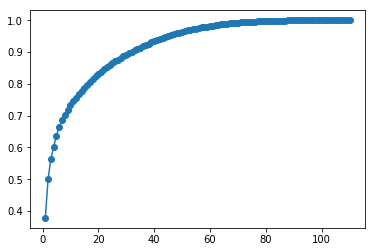

In [111]:
plt.plot(range(1, n_components+1), cum_ratio, marker='o')
perfect_n_components = 70

In [112]:
df_encoded_training.iloc[:,index_beginning_actions:].values.shape

(3052, 110)

# PCA Visualisation

In [113]:
len(ar_encoded_training_reduced_ordered_actions_[:,2])

3052

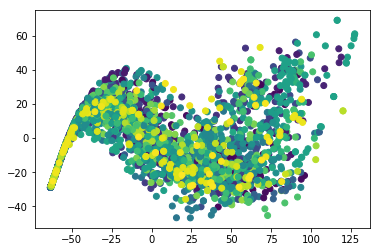

In [114]:
plt.scatter(ar_encoded_training_reduced_ordered_actions_[:,0],ar_encoded_training_reduced_ordered_actions_[:,2],c=df_encoded_training.id_player.values.tolist())

# PCA transformation

In [115]:
print(df_encoded_training.head())
columns_to_replace = df_encoded_training.columns[index_beginning_actions:]
df_encoded_training[columns_to_replace] = ar_encoded_training_reduced_ordered_actions_
print(df_encoded_training.head())
#res = np.equal(df_encoded_training.iloc[:,index_beginning_actions],ar_encoded_training_reduced_ordered_actions_[:,1])
#np.unique(res, return_counts=True)

   id_player  played_race  time_match  average_speed_match  0th_action  \
0          0            3      1655.0             0.740824        28.0   
1          1            3      1655.0             0.796056        26.0   
2          0            3      1010.0             0.748148        28.0   
3          1            3      1005.0             0.723022        28.0   
4          0            3       540.0             0.869565        28.0   

   1th_action  2th_action  3th_action  4th_action  5th_action      ...       \
0        26.0        26.0        26.0        26.0        26.0      ...        
1        28.0        26.0        26.0        28.0        26.0      ...        
2        26.0        26.0        26.0        28.0        26.0      ...        
3        26.0        26.0        28.0        26.0        26.0      ...        
4        26.0        26.0        26.0        28.0        26.0      ...        

   100th_action  101th_action  102th_action  103th_action  104th_action  \
0    

In [116]:
#df_encoded_training = __delete_columns_for_lower_limit__(df_encoded_training, perfect_n_components+index_beginning_actions, len(df_encoded_training.columns))

In [117]:
df_encoded_training.head()

,id_player,played_race,time_match,average_speed_match,0th_action,1th_action,2th_action,3th_action,4th_action,5th_action,...,100th_action,101th_action,102th_action,103th_action,104th_action,105th_action,106th_action,107th_action,108th_action,109th_action
0,0,3,1655.0,0.740824,-56.946610,26.709197,-11.987108,0.503873,-0.995512,10.236948,...,0.001251,0.001295,-0.001534,-0.000190,-2.637015e-14,-1.493099e-14,-5.189852e-15,7.586699e-15,-4.955354e-15,9.117743e-15
1,1,3,1655.0,0.796056,-12.371899,-23.956955,11.524681,-29.747882,25.630453,6.544028,...,-0.000284,-0.025924,-0.002708,0.000092,1.239014e-14,1.918393e-14,-1.401873e-14,-8.252069e-15,1.811952e-14,1.128480e-15
2,0,3,1010.0,0.748148,-59.395159,31.811927,-18.711830,5.766217,7.665951,-1.861947,...,-0.004105,-0.000205,0.002514,0.000144,8.980267e-15,-3.345503e-14,1.892807e-14,-5.311809e-15,-7.977376e-16,7.675558e-16
3,1,3,1005.0,0.723022,-44.635147,5.413303,12.822910,-24.230876,-8.556701,17.941329,...,-0.007267,-0.012586,-0.000742,-0.000654,4.474746e-14,5.825285e-16,2.029726e-14,2.376188e-15,5.719620e-15,1.889114e-15
4,0,3,540.0,0.869565,-59.395159,31.811927,-18.711830,5.766217,7.665951,-1.861947,...,-0.004105,-0.000205,0.002514,0.000144,-8.322662e-15,1.462900e-14,-5.722047e-15,-1.347154e-14,-8.304580e-15,-1.401707e-15


# Selection of model

In [118]:
model = RandomForestClassifier(n_estimators = 64, max_depth = 512)

# Training

In [ ]:
decision_tree.fit(df_encoded_training.iloc[:, 1:].values, df_encoded_training.id_player.values)

# Testing

In [ ]:
predicted = decision_tree.predict(df_encoded_testing.values)
decoded_predicted = encoder.decode_labels(predicted)  # We decode the encoded predictions
indices = range(1, len(predicted) + 1)
output_df = pd.DataFrame({"RowId": indices, "prediction": decoded_predicted})
output_df.to_csv("test_labels.CSV", index=False)

# Small validation

In [ ]:
nolabel_df_validation = df_encoded_testing.drop(axis=1, labels="id_player")
nolabel_df_validation.fillna(0)
predicted = decision_tree.predict(nolabel_df_validation.values)
labels = df_encoded_testing.id_player.values
print("accuracy:", accuracy_extractor.get_accuracy(labels, predicted))

# k-fold cross validation

In [ ]:
k = 10
scores = cross_val_score(model, df_encoded_training.iloc[:, 1:].values, y=df_encoded_training.id_player.values, cv=k)
print(scores)

# Save all PCA computing scores

In [119]:
k = 10
scores_for_ns_components = dict()
df_encoded_training_safe = df_encoded_training
for n_components in range(1, 80, 10):
    df_encoded_training = __delete_columns_for_lower_limit__(df_encoded_training, n_components+index_beginning_actions, len(df_encoded_training.columns))
    columns_to_replace = df_encoded_training.columns[index_beginning_actions:]
    model = RandomForestClassifier(n_estimators = 64, max_depth = 512)
    scores = cross_val_score(model, df_encoded_training.iloc[:, 1:].values, y=df_encoded_training.id_player.values, cv=k)
    scores_for_ns_components[n_components] = scores
    df_encoded_training = df_encoded_training_safe

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Program Files (x86)\Microsoft Visu

In [120]:
dict_mean = dict()
for nb_components, arr in scores_for_ns_components.items():
    dict_mean[nb_components] = sum(arr)/10
    print(nb_components)
    print(sum(arr)/10)

1
0.27643071050187007
11
0.4796153209275461
21
0.5250914162615565
31
0.49519045723130584
41
0.49682459878840185
51
0.49265997267716183
61
0.48577748805093623
71
0.47066933683447604


In [121]:
dict_mean

{1: 0.27643071050187007,
 11: 0.4796153209275461,
 21: 0.5250914162615565,
 31: 0.49519045723130584,
 41: 0.49682459878840185,
 51: 0.49265997267716183,
 61: 0.48577748805093623,
 71: 0.47066933683447604}

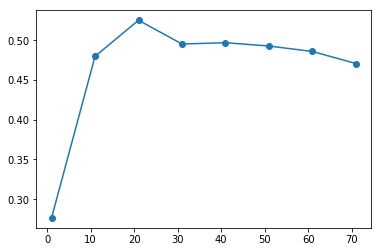

In [122]:
x = list(dict_mean.keys())
y_scores = list(dict_mean.values())
plt.plot(x, y_scores, marker='o')